In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, Subtract, Multiply, Average

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [ ]:

# zip_file_path = '/content/drive/MyDrive/glove.6B.zip'

# extract_path = '/content/drive/My Drive/Glove_embedding'
# import zipfile
# import os

# os.makedirs(extract_path, exist_ok=True)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f'Files extracted to {extract_path}')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/drive')


In [ ]:
with open('/content/drive/MyDrive/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('/content/drive/MyDrive/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
print(train_data)

['2968182121_b3b491df85', '2906054175_e33af79522', '2450299735_62c095f40e', '461505235_590102a5bf', '2751567262_e089b33ed9', '3595398879_13e33b8916', '3144705706_391d7b77c7', '2148916767_644ea6a7fa', '930126921_1b94605bdc', '2423138514_950f79e432', '3211316116_a2462e327d', '3043685748_130db75e3b', '180506881_de0f59770f', '2573625591_70291c894a', '1055623002_8195a43714', '1358089136_976e3d2e30', '3197482764_2f289cb726', '3556037801_3992ce6826', '3683185795_704f445bf4', '242558556_12f4d1cabc', '3498417123_3eae6bbde6', '543363241_74d8246fab', '3479050296_65bcea69a0', '976392326_082dafc3c5', '3688005475_d200165cf7', '2826647354_650ff5eb03', '2922512807_d382528a93', '3283626303_8e23d4a842', '3186556417_b2d6921a20', '3417037373_67f7db2dd2', '3247598959_5b2348444c', '2939464283_fc1a834976', '2535746605_8124bf4e4f', '3028404926_2bd27e3e83', '245442617_407eba1e98', '3563461991_de05537878', '3415578043_03d33e6efd', '2780087302_6a77658cbf', '3495453699_1c9faedf3c', '2600442766_e750ec9a56', '28567

In [ ]:
token_path = "/content/drive/MyDrive/captions.txt"
# train_images_path = '../input/flickr8k/Data/Flickr8k_text/Flickr_8k.trainImages.txt'
# test_images_path = '/kaggle/input/flickr8k/Images'
images_path = '/content/drive/My Drive/img_img_cap_gen/'
glove_path = '/content/drive/MyDrive/Glove_embedding'
doc = open(token_path,'r').read()
print(doc[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


In [ ]:
# drive.flush_and_unmount()

In [ ]:
descriptions = dict()
for line in doc.split('\n'):
    tokens = line.split()
    if len(line) > 2:
        image_id = tokens[0].split('.')[0]
        image_desc = ' '.join(tokens[1:])
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)

In [ ]:
# Assuming the descriptions dictionary has already been created as described earlier
image_id = '1001773457_577c3a7d70'
caption_index = 1  # Index for the second caption (0-based index)

# Access the second caption
second_caption = descriptions[image_id][0:]
print(second_caption)


['black dog and a spotted dog are fighting', 'black dog and a tri-colored dog playing with each other on the road .', 'black dog and a white dog with brown spots are staring at each other in the street .', 'dogs of different breeds looking at each other on the road .', 'dogs on pavement moving toward each other .']


In [ ]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)
#text cleaned

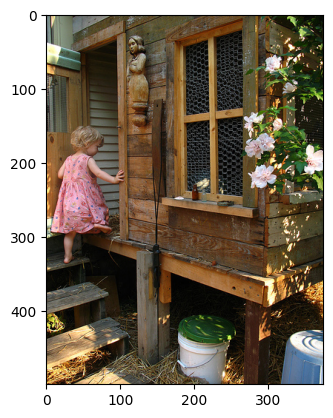

['boy in blue carries a bucket ',
 'boy in blue swim trunks carries a blue bucket down a crowded beach ',
 'child walks on the beach with a bucket ',
 'boy in the blue shorts is carrying a bucket on the beach ',
 'boy in blue shorts at the beach ']

In [ ]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['823675317_b5fbdb17b3']
#sample

In [ ]:
vocal = set()
for image_id, captions in descriptions.items():
    for d in descriptions[image_id]:
        vocal.update(d.split())
#stores all the word

In [ ]:
print(len(vocal))

8745


In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        if len(desc) > 2:
            lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)
print(new_descriptions[0:100])
#cleaned pair

1000268201_693b08cb0e child in a pink dress is climbing up a set of stairs in an entry way 
10002682


In [ ]:
path1=set()
t=list()
doc2= open(token_path,'r').read()
for line in doc2.split('\n'):
    tokens = line.split()
    if len(line) > 4:
        image_id = tokens[0].split('.')[0]
        t.append(image_id)
path1=set(t)
path1=list(path1)

In [ ]:
img_with_jpg=set()
t1=list()
doc2= open(token_path,'r').read()
for line in doc2.split('\n'):
    tokens = line.split()
    if len(line) > 8:
        image_id = tokens[0].split(',')[0]
        t1.append(image_id)
img_with_jpg=set(t1)
img_with_jpg=list(img_with_jpg)

In [ ]:
print(len(path1))
#stores all the image id's

8092


In [ ]:
# from sklearn.model_selection import train_test_split

In [ ]:
# train_data, test_data = train_test_split(path1, test_size=0.25, random_state=42)

# # Save the train data to a text file
# with open('train_data.txt', 'w') as train_file:
#     for item in train_data:
#         train_file.write(item + '\n')
# train_file.close()

# # Save the test data to a text file
# with open('test_data.txt', 'w') as test_file:
#     for item in test_data:
#         test_file.write(item + '\n')
# test_file.close()

In [ ]:
type(train_data)
#performed the train test split

list

In [ ]:
train_img=list()
test_img=list()
for i in range(len(img_with_jpg)):
    for j in range(len(train_data)):
        if train_data[j]==img_with_jpg[i].split('.')[0]:
            train_img.append(img_with_jpg[i])
            break

In [ ]:
for i in range(len(img_with_jpg)):
    for j in range(len(test_data)):
        if test_data[j]==img_with_jpg[i].split('.')[0]:
            test_img.append(img_with_jpg[i])
            break

In [ ]:
print(len(test_img))

2023


In [ ]:
img = glob.glob(images_path + '*.jpg')
train_images = set(train_img)
train_img1 = []
for i in img:
    if i[len(images_path):] in train_images:
        train_img1.append(i)

test_images = set(test_img)
test_img1 = []
for i in img:
    if i[len(images_path):] in test_images:
        test_img1.append(i)

In [ ]:
print(train_img)

['2699733386_c346c87ea6.jpg', '2837127816_24441e5f7c.jpg', '3266406566_d64e57e65a.jpg', '1459032057_97e73ed6ab.jpg', '251958970_fa6b423f23.jpg', '541046380_513e295384.jpg', '3472066410_065b4f99d3.jpg', '1303550623_cb43ac044a.jpg', '2629445284_83390e83af.jpg', '2270483627_16fe41b063.jpg', '590445887_4d4fa43923.jpg', '3215695965_69fbeba3d5.jpg', '3530342993_a4a1f0e516.jpg', '3670918456_68631d362a.jpg', '3680218298_582e6a2289.jpg', '2913818905_8e4d9aa82a.jpg', '1597557856_30640e0b43.jpg', '2939197393_93dc64c4bb.jpg', '3506869953_802f463178.jpg', '2295750198_6d152d7ceb.jpg', '3627679667_0e3de9fc90.jpg', '2642474867_4e6346f809.jpg', '2586911841_41b7a48c91.jpg', '1232148178_4f45cc3284.jpg', '3323952123_deb50b0629.jpg', '3396043950_12783c5147.jpg', '3508637029_89f3bdd3a2.jpg', '3712742641_641282803e.jpg', '1417637704_572b4d6557.jpg', '2960759328_2d31e4af9b.jpg', '3593222804_c187808ac3.jpg', '3282121432_648dac8a29.jpg', '3399843227_3b9d2a8dbf.jpg', '3335773346_ac0d97efeb.jpg', '180506881_de0f5

In [ ]:
train_dict = dict()
for line in new_descriptions.split('\n'):
    t = line.split()
    id1, desc = t[0], t[1:]
    if id1 in train_data:
        if id1 not in train_dict:
            train_dict[id1] = list()
        desc1 = 'start ' + ' '.join(desc) + ' end'
        train_dict[id1].append(desc1)


In [ ]:
print(train_dict['823675317_b5fbdb17b3'])
#train in dict format

['start boy in blue carries a bucket end', 'start boy in blue swim trunks carries a blue bucket down a crowded beach end', 'start child walks on the beach with a bucket end', 'start boy in the blue shorts is carrying a bucket on the beach end', 'start boy in blue shorts at the beach end']


In [ ]:
train_cap=list()
for line,t in train_dict.items():
    for r in t:
        train_cap.append(r)

In [ ]:
print(len(train_cap))
#stored the desc of train data

30339


In [ ]:

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in train_cap:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocal1 = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocal1)))

Vocabulary = 1676


In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocal1:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [ ]:
print(vocab_size)

1677


In [ ]:
all_desc = list()
for key in train_dict.keys():
    [all_desc.append(d) for d in train_dict[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 37


In [ ]:
 embeddings_index = {}
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# model = InceptionV3(weights='imagenet')

In [ ]:
# from tensorflow.keras.applications import EfficientNetB3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import load_model
import os

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
base_model = EfficientNetB0(include_top=False, weights='imagenet')
model_new = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
# import tensorflow as tf

# model_path = '/kaggle/input/efficientnet/tensorflow2/b3-classification/1'
# model = tf.saved_model.load(model_path)


In [ ]:
# infer = model.signatures["serving_default"]

In [ ]:
# def preprocess(image_path):
#     img = image.load_img(image_path, target_size=(299, 299))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)
#     return x

In [ ]:
train_data=list(train_data)
test_data=list(test_data)

In [ ]:
# def preprocess(image_path):  this
#     # Load the image
#     img = image.load_img(image_path, target_size=(299, 299))
#     # Convert the image to a numpy array
#     img_array = image.img_to_array(img)
#     # Expand dimensions to match the shape [1, 299, 299, 3]
#     img_array = np.expand_dims(img_array, axis=0)
#     # Preprocess the image
#     img_array = preprocess_input(img_array)
#     return img_array

In [ ]:
def preprocess(path):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def encode(path):
    image = preprocess(path)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, (fea_vec.shape[-1],))
    return fea_vec

# Example usage



In [ ]:
# def encode(image_path):this
#     # Preprocess the image
#     image = preprocess(image_path)  # Preprocess the image to the required input format

#     # Make predictions using the model
#     output = model.predict(image)

#     # Assuming the output is a feature vector (modify if different)
#     fea_vec = output[0]  # Since output is already in the desired shape

#     return fea_vec

In [ ]:
pathoftrain=[]
for img in train_img:
    pathoftrain.append(images_path+img)

In [ ]:
pathoftest=[]
for img in test_img:
    pathoftest.append(images_path+img)
print(pathoftest)

['/content/drive/My Drive/img_img_cap_gen/2739331794_4ae78f69a0.jpg', '/content/drive/My Drive/img_img_cap_gen/273248777_eaf0288ab3.jpg', '/content/drive/My Drive/img_img_cap_gen/2895403073_906768cafa.jpg', '/content/drive/My Drive/img_img_cap_gen/3534183988_3763593dfb.jpg', '/content/drive/My Drive/img_img_cap_gen/2854207034_1f00555703.jpg', '/content/drive/My Drive/img_img_cap_gen/2473791980_805c819bd4.jpg', '/content/drive/My Drive/img_img_cap_gen/3227140905_1d7e30e4c4.jpg', '/content/drive/My Drive/img_img_cap_gen/2198964806_c57b0534d3.jpg', '/content/drive/My Drive/img_img_cap_gen/3702607829_2b8b3e65ab.jpg', '/content/drive/My Drive/img_img_cap_gen/141139674_246c0f90a1.jpg', '/content/drive/My Drive/img_img_cap_gen/3583321426_f373c52161.jpg', '/content/drive/My Drive/img_img_cap_gen/3100251515_c68027cc22.jpg', '/content/drive/My Drive/img_img_cap_gen/313326614_b2adbe59e0.jpg', '/content/drive/My Drive/img_img_cap_gen/3598447435_f66cd10bd6.jpg', '/content/drive/My Drive/img_img_cap

In [ ]:
encoding_train_1 = {}
print(len(encoding_train_1 ))

0


In [ ]:

# for img in pathoftrain:
#     encoding_train_1[img[len(images_path):]] = encode(img)
# train_features_1 = encoding_train_1


In [ ]:
print(pathoftest[0])

/content/drive/My Drive/img_img_cap_gen/2739331794_4ae78f69a0.jpg


In [ ]:
# infer = model.signatures["serving_default"]

In [ ]:
# encoding_test = {}
# for img in pathoftest:
#     encoding_test[img[len(images_path):]] = encode(img)
# test_features = encoding_test
# print("DONE TEST ENCODING")

In [ ]:
# encoding_train = {}
# for img in pathoftrain:
#     encoding_train[img[len(images_path):]] = encode(img)
# train_features_1 = encoding_train
# print("DONE")

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/encoding_test.pkl', 'rb') as f:
    encoding_test = pickle.load(f)
with open('/content/drive/MyDrive/train_features_1.pkl', 'rb') as f:
    train_features_1 = pickle.load(f)
# with open('/content/drive/MyDrive/encoding_train_1.pkl', 'wb') as f:
#     pickle.dump(encoding_train_1,f)

In [ ]:
# train_features.shape

In [ ]:
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
# print(loaded_encoding_train[0:10])

In [ ]:
# preprocess_images(train_data)
# preprocess_images(test_data)
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from keras.models import Model

In [ ]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, add



In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=4e-6)
        self.layernorm2 = LayerNormalization(epsilon=4e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        print(f"Input shape: {inputs.shape}")
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        print(f"Output shape: {ffn_output.shape}")
        return self.layernorm2(out1 + ffn_output)


In [ ]:
inputs1 = Input(shape=(1280,))
inputs2 = Input(shape=(max_length,))

fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = TransformerBlock(embed_dim=embedding_dim, num_heads=4, ff_dim=128)(se2)
se4 = Flatten()(se3)

se5 = Dense(256, activation='relu')(se4)
decoder1 = add([fe2, se5])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

#model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5)  # Lower learning rate
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])



Input shape: (None, 32, 200)
Output shape: (None, 32, 200)


In [ ]:
embedding_layer = model.get_layer(index=1)
embedding_layer.set_weights([embedding_matrix])
embedding_layer.trainable = False

In [ ]:
# model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam')
print(inputs2.shape)  # Image feature shape
print(se2.shape)
print(se3.shape)
print(se4.shape)
print(fe2.shape)
print(se5.shape)
print(outputs.shape)



(None, 37)
(None, 37, 200)
(None, 37, 200)
(None, 7400)
(None, 256)
(None, 256)
(None, 1677)


In [ ]:
def data_generator(train_dict, train_features_1, wordtoix, max_length, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key, desc_list in train_dict.items():
            feature = train_features_1[key]  # Retrieve the photo feature
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)  # Ensure out_seq is not one-hot encoded

                    n += 1
                    if n == batch_size:
                        X1 = np.array(X1)
                        X2 = np.array(X2)
                        y = np.array(y)
                        print(f"Batch shapes - X1: {X1.shape}, X2: {X2.shape}, y: {y.shape}")
                        yield ([X1, X2], y)
                        X1, X2, y = [], [], []
                        n = 0


In [ ]:
# train_dict_with = {key + '.jpg': value for key, value in train_dict.items()}

# train_dict = train_dict_with
# print(train_dict)

{'1000268201_693b08cb0e.jpg': ['start child in a pink dress is climbing up a set of stairs in an entry way end', 'start girl going into a wooden building end', 'start little girl climbing into a wooden playhouse end', 'start little girl climbing the stairs to her playhouse end', 'start little girl in a pink dress going into a wooden cabin end'], '1002674143_1b742ab4b8.jpg': ['start little girl covered in paint sits in front of a painted rainbow with her hands in a bowl end', 'start little girl is sitting in front of a large painted rainbow end', 'start small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end', 'start is a girl with pigtails sitting in front of a rainbow painting end', 'start girl with pigtails painting outside in the grass end'], '1003163366_44323f5815.jpg': ['start man lays on a bench while his dog sits by him end', 'start man lays on the bench to which a white dog is also tied end', 'start man sleeping on a bench outside wit

In [ ]:
print(train_dict['2565237642_bdd46d7cef.jpg'])

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_dict) // batch_size

generator = data_generator(train_dict, train_features_1, wordtoix, max_length, batch_size)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[early_stopping])



In [ ]:
img_cap=model

In [ ]:
img_cap.save('/content/drive/MyDrive/img_cap.h5')

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["start"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'end':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

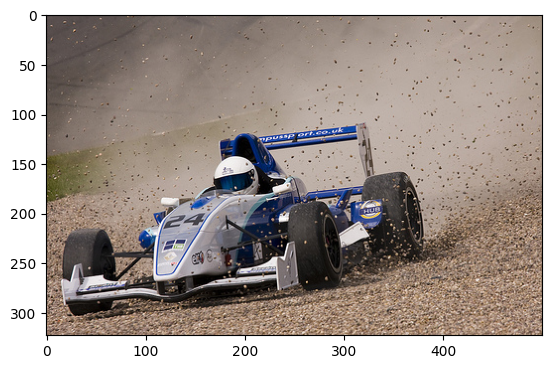

Greedy Search: man a a a a a a end end end end end end end end end end end end end end end end end end end end end end end end end end end end end
Beam Search, K = 3: man man in a a a a a a a a a a man is man girl girl is is is is is is is
Beam Search, K = 5: man man in a a a in a a a a a a a a a is is is is is is
Beam Search, K = 7: man man in a a a in a a a a a a a a a a is is is is is
Beam Search, K = 10: man man in a a a a a a man a in a a a a a is is is is is


In [ ]:
pic = test_data[99]+'.jpg'
image = encoding_test[pic].reshape((1,1280))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))